# Предсказание оттока сотрудников

Соревнование Kaggle: 
https://www.kaggle.com/t/e703142015c049318340d699fe881c36

Описание файлов
- train_data.csv - набор данных для обучения
- test_data.csv - набор данных для теста

Описание полей
- Age - возраст
- BusinessTravel - частота командировок
- Department - отдел
- DistanceFromHome - расстояние от дома в км
- Education - уровень образования
- EducationField - сфера образования
- Gender - пол
- JobRole - должностная роль
- MaritalStatus - семейное положение
- MonthlyIncome - ежемесячный доход
- NumCompaniesWorked - кол-во компаний, в которых работал сотрудник
- PercentSalaryHike - процент повышения з/п за время работы
- StandardHours - стандартная продолжительность рабочего дня
- StockOptionLevel - уровень опциона на акции
- TotalWorkingYears - общий трудовой стаж
- TrainingTimesLastYear - общее время дополнительного обучения
- YearsAtCompany - стаж работы в данной компании
- YearsSinceLastPromotion - кол-во лет с последнего повышения
- YearsWithCurrManager - кол-во лет работы с текущим менеджером
- *Attrition - ушел работник или нет, целевая переменная*

## Загружаем и чистим данные

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn import linear_model, ensemble
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

In [2]:
%%capture
!wget https://www.dropbox.com/s/z72mi1fh0cmadcv/train_data.csv
!wget https://www.dropbox.com/s/7mzi72914hpo74t/test_data.csv

In [3]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [4]:
# убираем задвоенный индекс
train_data.drop(['Unnamed: 0'], axis=1, inplace=True)
test_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [5]:
#видим, что столбцы с числами в формате числа, это хорошо; объекты типа object закодируем далее
train_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      2205 non-null   int64  
 1   BusinessTravel           2205 non-null   object 
 2   Department               2205 non-null   object 
 3   DistanceFromHome         2205 non-null   int64  
 4   Education                2205 non-null   int64  
 5   EducationField           2205 non-null   object 
 6   Gender                   2205 non-null   object 
 7   JobRole                  2205 non-null   object 
 8   MaritalStatus            2205 non-null   object 
 9   MonthlyIncome            2205 non-null   int64  
 10  NumCompaniesWorked       2194 non-null   float64
 11  PercentSalaryHike        2205 non-null   int64  
 12  StandardHours            2205 non-null   int64  
 13  StockOptionLevel         2205 non-null   int64  
 14  TotalWorkingYears       

In [6]:
train_data.head()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,40,Travel_Rarely,Research & Development,2,3,Medical,Male,Research Director,Single,47750,3.0,15,8,1,15.0,3,5,1,0,1
1,31,Travel_Rarely,Research & Development,28,4,Technical Degree,Female,Sales Executive,Married,127420,1.0,11,8,0,10.0,4,10,0,2,0
2,35,Travel_Frequently,Research & Development,3,3,Medical,Female,Laboratory Technician,Married,22580,1.0,11,8,1,2.0,2,2,2,2,0
3,33,Travel_Rarely,Research & Development,2,2,Medical,Male,Sales Executive,Single,24400,0.0,18,8,3,4.0,4,3,0,2,0
4,32,Travel_Rarely,Research & Development,2,3,Medical,Male,Research Scientist,Married,57470,1.0,13,8,0,8.0,0,8,0,7,0


In [8]:
# заменим некоторые переменные значениями для упрощения анализа
train_data['BusinessTravel'] = train_data['BusinessTravel'].replace('Travel_Rarely', 1)
train_data['BusinessTravel'] = train_data['BusinessTravel'].replace('Travel_Frequently', 2)
train_data['BusinessTravel'] = train_data['BusinessTravel'].replace('Non-Travel', 0)
train_data['Gender'] = train_data['Gender'].replace('Male', 1)
train_data['Gender'] = train_data['Gender'].replace('Female', 0)

test_data['BusinessTravel'] = test_data['BusinessTravel'].replace('Travel_Rarely', 1)
test_data['BusinessTravel'] = test_data['BusinessTravel'].replace('Travel_Frequently', 2)
test_data['BusinessTravel'] = test_data['BusinessTravel'].replace('Non-Travel', 0)
test_data['Gender'] = test_data['Gender'].replace('Male', 1)
test_data['Gender'] = test_data['Gender'].replace('Female', 0)

In [9]:
#посмотрим статистику, транспонируем для удобства
train_data.describe().T 

,count,mean,std,min,25%,50%,75%,max
Age,2205.0,36.669841,9.078445,18.0,30.0,35.0,42.0,60.0
BusinessTravel,2205.0,1.073469,0.542269,0.0,1.0,1.0,1.0,2.0
DistanceFromHome,2205.0,9.409524,8.134342,1.0,2.0,7.0,15.0,29.0
Education,2205.0,2.895692,1.046125,1.0,2.0,3.0,4.0,5.0
Gender,2205.0,0.592290,0.491520,0.0,0.0,1.0,1.0,1.0
MonthlyIncome,2205.0,65151.972789,47711.864224,10510.0,28750.0,48770.0,83460.0,199990.0
NumCompaniesWorked,2194.0,2.648587,2.490846,0.0,1.0,2.0,4.0,9.0
PercentSalaryHike,2205.0,15.209524,3.638322,11.0,12.0,14.0,18.0,25.0
StandardHours,2205.0,8.000000,0.000000,8.0,8.0,8.0,8.0,8.0
StockOptionLevel,2205.0,0.822222,0.874708,0.0,0.0,1.0,1.0,3.0


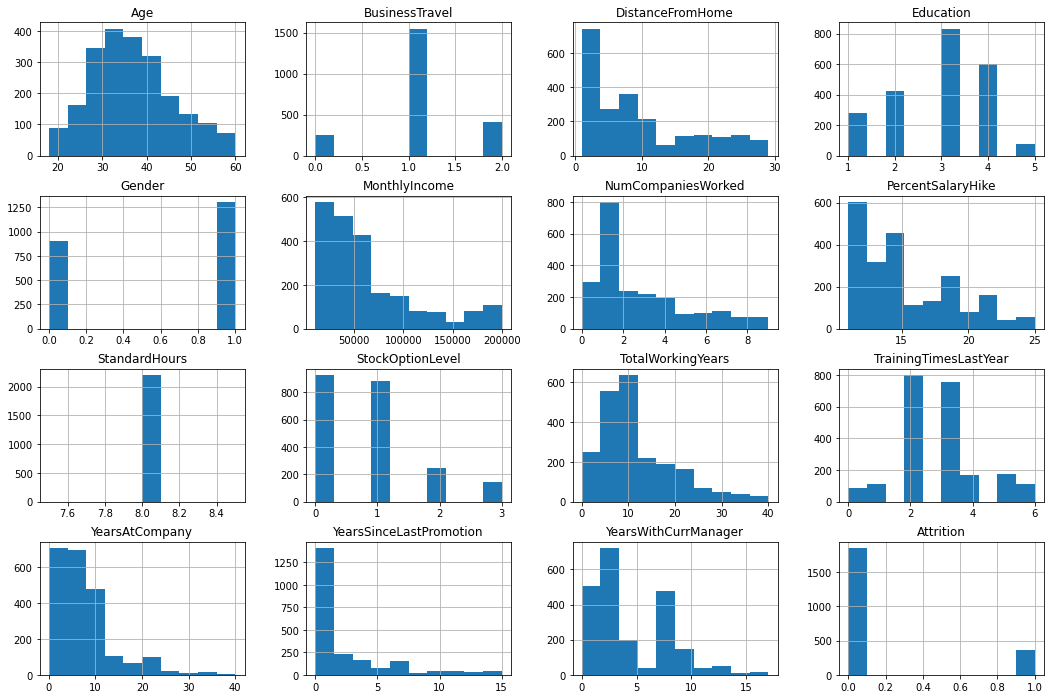

In [10]:
# посмотрим возможные выбросы
train_data.hist(figsize=(18, 12));

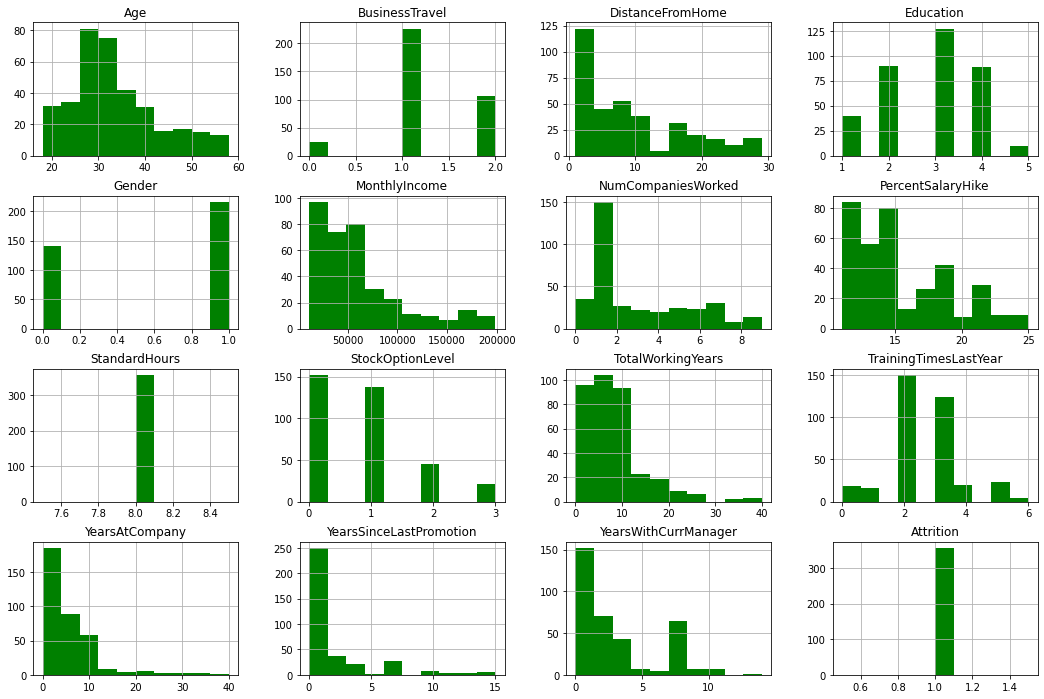

In [11]:
# видим, что чаще всего увольняются сотрудники в возрасте 25 - 33, проработавшие в компании менее 2-3 лет, которые чаще других ездили в командировки 
# остальные характеристики не сильно отличаются от средних значений по всей выборке 
train_data[train_data['Attrition'] == 1].hist(figsize=(18, 12), color = "green");

In [12]:
# уберем близких к пенсии и уровень образорвания "5"
train_data = train_data[
    (train_data['Education'] <= 4) &
    (train_data['TotalWorkingYears'] < 24) 
]
train_data.describe().T 

,count,mean,std,min,25%,50%,75%,max
Age,1939.0,35.385250,8.274048,18.0,30.0,35.0,40.0,60.0
BusinessTravel,1939.0,1.074781,0.545247,0.0,1.0,1.0,1.0,2.0
DistanceFromHome,1939.0,9.384219,8.131046,1.0,2.0,7.0,15.0,29.0
Education,1939.0,2.826199,0.978729,1.0,2.0,3.0,4.0,4.0
Gender,1939.0,0.597731,0.490482,0.0,0.0,1.0,1.0,1.0
MonthlyIncome,1939.0,65872.919030,48222.261147,10510.0,29065.0,49630.0,84685.0,199990.0
NumCompaniesWorked,1930.0,2.553368,2.491770,0.0,1.0,1.0,4.0,9.0
PercentSalaryHike,1939.0,15.214028,3.650931,11.0,12.0,14.0,18.0,25.0
StandardHours,1939.0,8.000000,0.000000,8.0,8.0,8.0,8.0,8.0
StockOptionLevel,1939.0,0.813822,0.869679,0.0,0.0,1.0,1.0,3.0


In [13]:
#посчитаем медиану и заполним ими пустые значения в таблице
train_median = train_data.median() 
train_data.fillna(train_median, inplace=True)

test_median = test_data.median()
test_data.fillna(test_median, inplace=True)

train_median

Age                           35.0
BusinessTravel                 1.0
DistanceFromHome               7.0
Education                      3.0
Gender                         1.0
MonthlyIncome              49630.0
NumCompaniesWorked             1.0
PercentSalaryHike             14.0
StandardHours                  8.0
StockOptionLevel               1.0
TotalWorkingYears              9.0
TrainingTimesLastYear          3.0
YearsAtCompany                 5.0
YearsSinceLastPromotion        1.0
YearsWithCurrManager           3.0
Attrition                      0.0
dtype: float64

In [14]:
#выделяем целевую переменну, обзначающую ушел работник или нет и отделим ее от входных данных
target_variable_name = 'Attrition' 
train_values = train_data[target_variable_name]
train_points = train_data.drop(target_variable_name, axis=1)

# задача не сбалансирована, уволиышихся сотрудников меньше
train_values.value_counts()

0    1605
1     334
Name: Attrition, dtype: int64

In [15]:
# проверим размерность стобцов
train_points.shape, train_values.shape

((1939, 19), (1939,))

In [16]:
# записываем столбец id в отдельную переменную, он нам понадобится в конце для итоговых результатов
idx = test_data['index'] 
test_points = test_data.drop('index', axis=1) # удаляем его из тестовой выборки

## Обработываем текстовые переменные

In [17]:
# выбираем кодировщик OneHotEncoder
train_points_new = pd.get_dummies(train_points)
test_points_new = pd.get_dummies(test_points)

In [18]:
# проверим, какая красота получилась
train_points_new.head(5)

,Age,BusinessTravel,DistanceFromHome,Education,Gender,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,40,1,2,3,1,47750,3.0,15,8,1,15.0,3,5,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,31,1,28,4,0,127420,1.0,11,8,0,10.0,4,10,0,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
2,35,2,3,3,0,22580,1.0,11,8,1,2.0,2,2,2,2,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,33,1,2,2,1,24400,0.0,18,8,3,4.0,4,3,0,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,32,1,2,3,1,57470,1.0,13,8,0,8.0,0,8,0,7,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


##   Обучаем модель

In [19]:
# используем градиентный бустинг
import xgboost as xgb 
xgboost_model = xgb.XGBClassifier(use_label_encoder=False, verbosity=0) # создаем прототип модели
xgboost_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, use_label_encoder=False, verbosity=0)

### Grid Search

In [20]:
# используем Grid search для поиска лучших параметров модели
# среди каких вариантов будем выбирать
param_grid = {
    'n_estimators': [150, 200, 250],
    'max_depth': [11, 12, 13],
    'learning_rate': [0.35, 0.4, 0.45]
}

In [21]:
# k-fold для кросс-валидации (количество разбиений)
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
kfold

KFold(n_splits=5, random_state=123, shuffle=True)

In [22]:
# запускаем Grid search для нашей модели, с вариантами поиска и количеством разбиений для кросс-валидации
CV_xgb = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, scoring='roc_auc', cv=kfold)

In [23]:
# положим наши данные в модель для поиска лучших параметров
CV_xgb.fit(train_points_new, train_values)

GridSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.35, 0.4, 

In [24]:
# наилучшие параметры 
best_params = CV_xgb.best_params_
best_params

{'learning_rate': 0.45, 'max_depth': 12, 'n_estimators': 150}

In [25]:
# сохраним в переменную, чтобы каждый раз не запускать сложный расчет
# best_params = {'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 300}
# best_params = {'learning_rate': 0.4, 'max_depth': 12, 'n_estimators': 200}

### XGBoost

In [26]:
# инициализируем модель с лучшими параметрами из Grid Search
best_xgb_model = xgb.XGBClassifier(use_label_encoder=False, verbosity=0, **best_params)

In [27]:
# сделаем кросс-валидацию и выведем roc_auc
roc_auc_scores = cross_val_score(best_xgb_model, train_points_new, train_values, cv=kfold, scoring='roc_auc')
roc_auc_scores

array([0.93557411, 0.91881061, 0.92652879, 0.90032169, 0.96265904])

In [28]:
roc_auc_scores.mean()

0.9287788494923703

In [29]:
# обучаем модель на обучающей выборке с лучшими параметрами модели
best_xgb_model.fit(train_points_new, train_values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.45, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, use_label_encoder=False, verbosity=0)

In [30]:
# получим предсказани; целевая метрика - ROC AUC, поэтому нужно получить вероятности принадлежности к классу 1
test_predictions = best_xgb_model.predict_proba(test_points_new)[:, 1]
test_predictions

array([9.8334426e-01, 5.5264088e-04, 1.0008891e-03, ..., 5.0383288e-04,
       5.0740493e-03, 3.3098780e-02], dtype=float32)

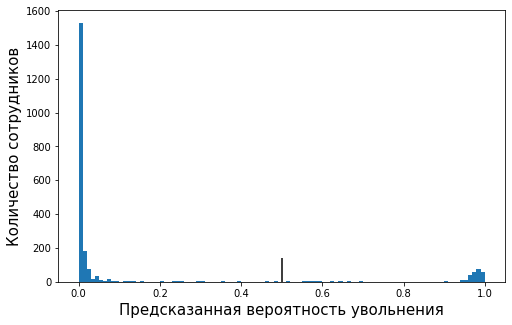

In [31]:
# изобразим на графике

plt.figure(figsize=(8, 5))
# строим распределение вероятностей 
plt.hist(test_predictions, bins=100)
# строим прямую линию в точке 0.5
plt.vlines(0.5, 0, 140)
plt.xlabel('Предсказанная вероятность увольнения', fontsize=15)
plt.ylabel('Количество сотрудников', fontsize=15);

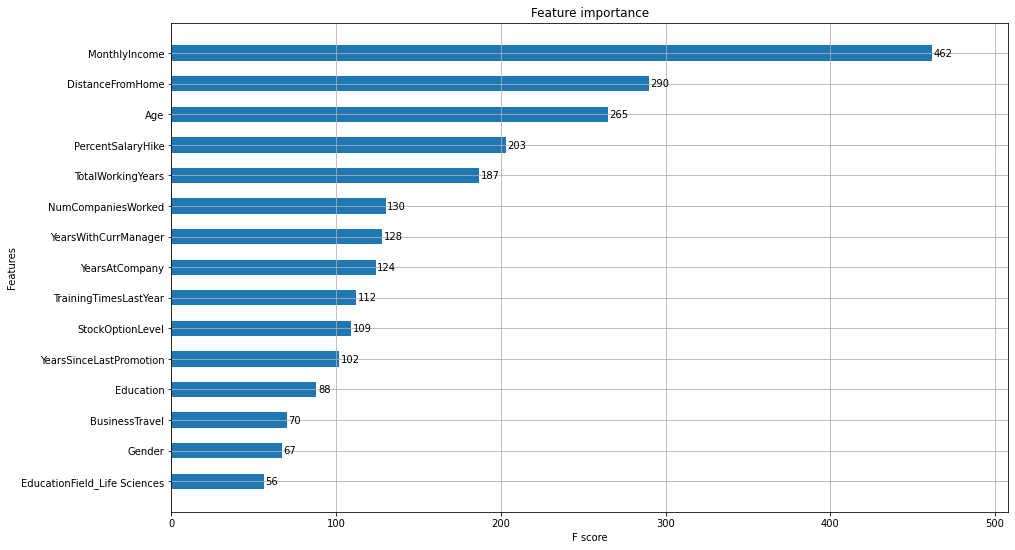

In [32]:
# посмотрим, какие именно факторы влияют на увольнение
fig, ax = plt.subplots(figsize=(15, 9))
xgb.plot_importance(best_xgb_model, max_num_features=15, height=0.5, ax=ax)
plt.show()

### Загрузка результатов

In [33]:
result = pd.DataFrame(columns=['index', 'Attrition']) # создадим таблицу и записываем в нее полученные данные
result['index'] = idx
result['Attrition'] = test_predictions

In [34]:
# сохраняем и загружаем полученный результат
result.to_csv('result.csv', index=False)
from google.colab import files
files.download('result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

_
_
_
_

## Другие модели

### Модель логистической регрессии

In [35]:
logistic_regression_model = linear_model.LogisticRegression()
logistic_regression_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
logistic_regression_model.fit(train_points_new, train_values)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
# провалидируем тренировочную модель
train_predictions = logistic_regression_model.predict(train_points_new)
sum(train_predictions)

0

In [38]:
print(accuracy_score(train_values, train_predictions))

0.8277462609592573


In [39]:
pd.DataFrame(confusion_matrix(train_values, train_predictions))

,0,1
0,1605,0
1,334,0


In [40]:
print(roc_auc_score(train_values, train_predictions))

0.5


In [41]:
# сделаем прогноз
test_predictions_logistic_regression = logistic_regression_model.predict(test_points_new)
sum(test_predictions_logistic_regression)

0

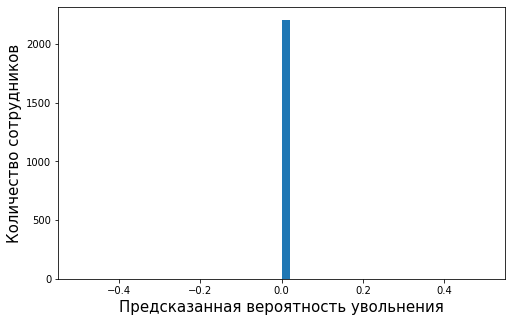

In [42]:
plt.figure(figsize=(8, 5))
plt.hist(test_predictions_logistic_regression, bins=50)
plt.xlabel('Предсказанная вероятность увольнения', fontsize=15)
plt.ylabel('Количество сотрудников', fontsize=15);

# так себе модель...

### Модель случайного леса

In [51]:
random_forest_model = ensemble.RandomForestClassifier(n_estimators=200)
random_forest_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [52]:
random_forest_model.fit(train_points_new, train_values)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [53]:
# провалидируем тренировочную модель
train_predictions = random_forest_model.predict(train_points_new)
sum(train_predictions)

334

In [54]:
print(accuracy_score(train_values, train_predictions))

1.0


In [55]:
pd.DataFrame(confusion_matrix(train_values, train_predictions))

,0,1
0,1605,0
1,0,334


In [56]:
print(roc_auc_score(train_values, train_predictions))

1.0


In [57]:
# сделаем прогноз
test_predictions_random_forest = random_forest_model.predict(test_points_new)
sum(test_predictions_random_forest)

260

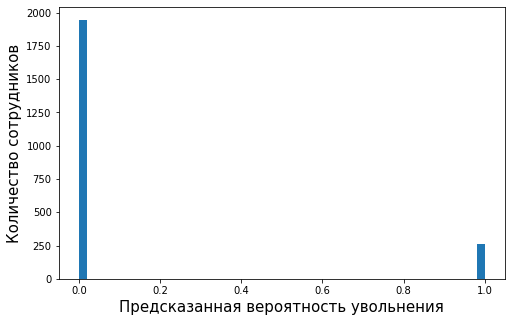

In [58]:
plt.figure(figsize=(8, 5))
plt.hist(test_predictions_random_forest, bins=50)
plt.xlabel('Предсказанная вероятность увольнения', fontsize=15)
plt.ylabel('Количество сотрудников', fontsize=15);

# отличная модель
# НО! нужно проверить на переобучение